# Comments
Paragraph selection:  
Calculate for each sentence in a section the ROUGE-1 (f1-measure) with the rest of the document (without the section), take the average over all sentences in a section to get the ROUGE score for the section. Select those sections with the highest ROUGE scores.

I also just added the abstract to the body of text and treated it as any other section.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets rouge

     |████████████████████████████████| 4.0 MB 4.6 MB/s 
     |████████████████████████████████| 325 kB 43.1 MB/s 
     |████████████████████████████████| 6.6 MB 33.7 MB/s 
     |████████████████████████████████| 77 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 14.2 MB/s 
     |████████████████████████████████| 895 kB 44.8 MB/s 
     |████████████████████████████████| 212 kB 55.4 MB/s 
     |████████████████████████████████| 1.1 MB 47.5 MB/s 
     |████████████████████████████████| 136 kB 55.3 MB/s 
     |████████████████████████████████| 127 kB 58.0 MB/s 
     |████████████████████████████████| 144 kB 56.4 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 58.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from rouge import Rouge
from multiprocessing import Pool
import os
import string

from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer
from datasets import load_dataset
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Parse Dataset
<mark>Run this locally, not on Colab, to use multiprocessing and speed this up.</mark>

In [ ]:
# import numpy as np
# import pandas as pd
# from pathlib import Path
# from tqdm import tqdm
# import re
# import matplotlib.pyplot as plt
# from rouge import Rouge
# from multiprocessing import Pool
# import os

# from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer
# from datasets import load_dataset
# import nltk.data
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# # nltk.download('punkt')
# # nltk.download('stopwords')

# # path_train = '/content/drive/MyDrive/Text-Mining/Data/Parsed_Papers_Train'
# # path_test = '/content/drive/MyDrive/Text-Mining/Data/Parsed_Papers_Test'



# def load_data(path, doc_name):
#     tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")
#     sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
#     stops = set(stopwords.words("english"))
#     rouge = Rouge(metrics=['rouge-1'])
#     path_generator = Path(path).glob('**/*.txt')
#     path_list = list(path_generator)

#     all_docs_df = pd.DataFrame(columns=['id', 'title', 'abstract', 'body', 'highlights', 'key_phrases'])

#     # test data parsing with a few sample docs
#     with Pool(16) as pool:
#         results = pool.map(read_file, [(p, sentence_tokenizer, stops, rouge, tokenizer) for p in path_list])

#     for r in results:
#         all_docs_df = all_docs_df.append(r, ignore_index=True)
    
#     if not doc_name.endswith('.tsv'):
#         doc_name = doc_name + '.tsv'
    
#     all_docs_df.to_csv(doc_name, sep='\t')



# def read_file(i):
#     (p, sentence_tokenizer, stops, rouge, tokenizer) = i
#     with open(p, 'r', encoding='utf-8') as f:
#         titles = ''
#         key_phrases = ''
#         # abstracts = ''
#         body = ''
#         section_titles_list = []
#         sections_list = []
#         section_lengths_list = []
#         section_rouge_list = []
#         highlights = ''
#         section = ''
#         id = p.stem
#         current_text = ''

#         for line in f:
#             if line == '\n':
#                 continue

#             # start new section
#             elif line.startswith('@&#'):
#                 if section == 'body':
#                     # process previous section
#                     # check if not empty string
#                     if current_text.strip():
#                         body += current_text.strip()
#                         # tokenise to count section length in case of subword usage by tokeniser
#                         tokenised = tokenizer(current_text.strip(), return_tensors='pt', truncation=False, padding=False)
#                         if not section_title is None:
#                             section_titles_list.append(section_title.group(0))
#                             section_lengths_list.append(tokenised.input_ids.size()[1])
#                             sections_list.append(current_text.strip())

#                 elif section == 'highlight':
#                     highlights += current_text.strip()
#                 elif section == 'key_phrase':
#                     key_phrases += current_text.strip()
#                 # elif section == 'abstract':
#                 #     abstracts += current_text.strip()
#                 elif section == 'title':
#                     titles += current_text.strip()
#                 elif section == 'keywords':
#                     pass
                
#                 current_text = ''
#                 # exclude tabs such that we don't have use quotes in the tsv
#                 line = re.sub(r'\t', ' ', line.strip())
#                 current_text += re.sub(r'@&#[A-Z- ]+@&#', '', line) + '\n' 
                
#                 if line.startswith('@&#MAIN-TITLE@&#'):
#                     section = 'title'
#                 elif line.startswith('@&#HIGHLIGHTS@&#'):
#                     section = 'highlight'
#                 elif line.startswith('@&#KEYPHRASES@&#'):
#                     section = 'key_phrase'
#                 elif line.startswith('@&#KEYWORDS@&#'):
#                     section = 'keywords'
#                 # elif line.startswith('@&#ABSTRACT@&#'):
#                 #     section = 'abstract'
#                 else:
#                     section = 'body'
#                     section_title = re.match(r'@&#[A-Z- ]+@&#', line)
#             else:
#                 current_text += line.strip() + '\n' 
        
#         # what remains in the end is just addded to the body part
#         body += current_text.strip()
#         if len(sections_list) > 1:
#             # calculate the ROUGE1-F1 between each section and the rest of the document
#             for i, section in enumerate(sections_list):
#                 other_sections = ' '.join([s for s in sections_list if s != section])
#                 # remove stopwords
#                 other_sections = ' '.join([word for word in word_tokenize(other_sections) if word.lower() not in stops])

#                 # get ROUGE score for each sentence and rest of text -> take the average over all sentences
#                 split_sentences = sentence_tokenizer.tokenize(section)
#                 rouge_scores_sentences = []
                
#                 for sentence in split_sentences:
#                     # remove stopwords
#                     sentence = ' '.join([word for word in word_tokenize(sentence) if word.lower() not in stops])
#                     try:
#                         rouge_scores = rouge.get_scores(sentence, other_sections, ignore_empty=True)
#                         f1_score = rouge_scores[0]['rouge-1']['f']  # or use recall -> results in nearly same selections later on
#                         rouge_scores_sentences.append(f1_score)

#                     # if sentences are emptey after stopword removal
#                     except ValueError:
#                         rouge_scores_sentences.append(0)


#                 mean_rouge_section = np.mean(np.asarray(rouge_scores_sentences))
#                 section_rouge_list.append(mean_rouge_section)

#                 # without averaging over sentences
#                 # rouge_scores = rouge.get_scores(section, other_sections, ignore_empty=True)
#                 # f1_score = rouge_scores[0]['rouge-1']['f']
#                 # section_rouge_list.append(f1_score)
#         else:
#             section_rouge_list.append(1)

#     return {'id': id, 'title': titles, 'body': body, 'highlights': highlights, 'key_phrases': key_phrases, 'sections_list': str(sections_list), 'section_lengths_list': str(section_lengths_list), 'section_titles_list': str(section_titles_list), 'section_rouge_list': str(section_rouge_list)}


# if __name__ == '__main__':
#     path_test = 'scientific-paper-summarisation-master\\Data\\Parsed_Papers_All_Titles_NoMathCite_Post\\Parsed_Papers_Test_All_Titles_NoMathCite_Post\\'
#     path_train = 'scientific-paper-summarisation-master\\Data\\Parsed_Papers_All_Titles_NoMathCite_Post\\Parsed_Papers_Train_All_Titles_NoMathCite_Post\\'
#     load_data(path_test, 'test_with_rouge_sent_avg')
#     load_data(path_train, 'train_with_rouge_sent_avg')

## Text Selection

### Baselines: Using Introduction (and Abstract)

In [ ]:
par_sel_shortened = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/paragraph_selection/train_with_shortened_3072.tsv', sep='\t').dropna(axis=0, subset=['highlights', 'shortened_articles'])

all_sections = par_sel_shortened['sections_list']
section_titles = par_sel_shortened['section_titles_list']

# only take introduction section
only_intro = []

for a in all_sections:
    a = eval(a)
    try:
        intro = a[1]
    # take abstract if there's no intro
    except:
        intro = a[0]
    only_intro.append(intro)

In [ ]:
# take both abstract and introduction
only_abstract_intro = []

for a in all_sections:
    a = eval(a)
    abstract_intro = ' '.join(a[:2])
    only_abstract_intro.append(abstract_intro)

In [ ]:
# train_df_intro = pd.DataFrame({'shortened_articles': only_intro, 'highlights': par_sel_shortened['highlights'].to_list()})
# train_df_abstract_intro = pd.DataFrame({'shortened_articles': only_abstract_intro, 'highlights': par_sel_shortened['highlights'].to_list()})
# train_df_intro.to_csv('train_with_intro.tsv', sep = '\t')
# train_df_abstract_intro.to_csv('train_with_abstract_intro.tsv', sep = '\t')

In [ ]:
# # extract data for test dfs
# par_sel_shortened_test = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/paragraph_selection/test_with_shortened_3072.tsv', sep='\t').dropna(axis=0, subset=['highlights', 'shortened_articles'])
# all_sections = par_sel_shortened_test['sections_list']
# section_titles = par_sel_shortened_test['section_titles_list']

# # only introduction
# only_intro = []

# for a in all_sections:
#     a = eval(a)
#     try:
#         intro = a[1]
#     except:
#         intro = a[0]
#     only_intro.append(intro)

# # introduction and abstract
# only_abstract_intro = []

# for a in all_sections:
#     a = eval(a)
#     abstract_intro = ' '.join(a[:2])
#     only_abstract_intro.append(abstract_intro)

# test_df_intro = pd.DataFrame({'shortened_articles': only_intro, 'highlights': par_sel_shortened_test['highlights'].to_list()})
# test_df_abstract_intro = pd.DataFrame({'shortened_articles': only_abstract_intro, 'highlights': par_sel_shortened_test['highlights'].to_list()})
# test_df_intro.to_csv('test_with_intro.tsv', sep = '\t')
# test_df_abstract_intro.to_csv('test_with_abstract_intro.tsv', sep = '\t')

### Paragraph Selection

In [ ]:
def shorten_sections(df, out_name, max_length):    
    selected_sections = dict()
    shortened_texts = []
    remove_from_df = []
    for i, row in df.iterrows():
        sections_list = eval(row['sections_list'])
        section_lengths_list = np.asarray(eval(row['section_lengths_list']))
        section_rouge_list = np.asarray(eval(row['section_rouge_list']))
        section_titles_list = eval(row['section_titles_list'])

        indices = np.argsort(-section_rouge_list)
        
        if section_lengths_list.size == 0:
            remove_from_df.append(i)
            continue

        current_length = 0
        for j, index in enumerate(indices):
            current_length += section_lengths_list[index]
            if current_length > max_length:
                selection_indices = np.sort(indices[:j])
                text = ''
                for s in selection_indices:
                    text += sections_list[s] + ' '
                    if section_titles_list[s] in selected_sections:
                        selected_sections[section_titles_list[s]] += 1
                    else:
                        selected_sections[section_titles_list[s]] = 1

                shortened_texts.append(text)
                break
            elif j == (len(indices)-1):
                selection_indices = np.sort(indices)
                text = ''
                for s in selection_indices:
                    text += sections_list[s] + ' '
                shortened_texts.append(text)
                break
    df.drop(remove_from_df, inplace=True)
    df['shortened_articles'] = shortened_texts
    
    # drop rows where there is no text after shortening
    df.dropna(axis=0, subset=['shortened_articles'], inplace=True)
    df.to_csv(out_name, sep = '\t')

    return selected_sections



In [ ]:
# test_df = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/before_shortening/test_with_rouge_sent_avg.tsv', sep='\t')
# train_df = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/before_shortening/train_with_rouge_sent_avg.tsv', sep='\t')
# selected_sections_test = shorten_sections(test_df, 'test_with_shortened_3072.tsv', 3072)
# selected_sections_train = shorten_sections(train_df, 'train_with_shortened_3072.tsv', 3072)


### Sentence Selection

In [ ]:
def select_sentences(df, out_name, max_length):    
    selected_sections = dict()
    shortened_texts = []
    remove_from_df = []
    df = df.dropna(axis=0, subset=['sentences', 'sentence_lengths', 'rouge_scores_sentences', 'part_of_section'])
                   
    for i, row in df.iterrows():
        sentence_list = eval(row['sentences'])
        sentence_length_list = eval(row['sentence_lengths'])
        rouge_list = np.asarray(eval(row['rouge_scores_sentences']))
        part_of_section = eval(row['part_of_section'])

        indices = np.argsort(-rouge_list)

        if rouge_list.size == 0:
            remove_from_df.append(i)
            continue

        current_length = 0
        for j, index in enumerate(indices):
            current_length += sentence_length_list[index]
            if current_length > max_length:
                selection_indices = np.sort(indices[:j])
                text = ''
                for s in selection_indices:
                    text += sentence_list[s] + ' '
                    if part_of_section[s] in selected_sections:
                        selected_sections[part_of_section[s]] += 1
                    else:
                        selected_sections[part_of_section[s]] = 1

                shortened_texts.append(text)
                break
            elif j == (len(indices)-1):
                selection_indices = np.sort(indices)
                text = ''
                for s in selection_indices:
                    text += sentence_list[s] + ' '
                shortened_texts.append(text)
                break
           
    df.drop(remove_from_df, inplace=True)
    df['shortened_articles'] = shortened_texts
    
    # drop rows where there is no text after shortening
    df.dropna(axis=0, subset=['shortened_articles'], inplace=True)
    df.to_csv(out_name, sep = '\t')

    return selected_sections


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/before_shortening/test_with_rouge_sent.tsv', sep='\t').dropna(axis=0, subset=['highlights','sentences'])
train_df = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/before_shortening/train_with_rouge_sent.tsv', sep='\t').dropna(axis=0, subset=['highlights', 'sentences'])
# selected_sections_test = select_sentences(test_df, 'test_with_shortened_sent_sel_3072.tsv', 3072)
# selected_sections_train = select_sentences(train_df, 'train_with_shortened_sent_sel_3072.tsv', 3072)

## Evaluate Selection

In [ ]:
def shortened_rec(shortened_texts, highlights):
    '''Returns ROUGE-1 recall of shortened texts and highlight statements, i.e. how much of the highlight statements is covered by the shortened texts.'''

    stops = set(stopwords.words("english"))

    proc_shortened_texts = []
    proc_highlights = []

    for s, h in zip(shortened_texts, highlights):
        # remove newlines, remove punctuation, lowercase
        s = s.replace('\n', ' ').strip().translate(str.maketrans('', '', string.punctuation)).lower()
        h = h.replace('\n', ' ').strip().translate(str.maketrans('', '', string.punctuation)).lower()

        # remove stopwords
        s = ' '.join([word for word in word_tokenize(s) if word not in stops])
        h = ' '.join([word for word in word_tokenize(h) if word not in stops])

        proc_shortened_texts.append(s)
        proc_highlights.append(h)

    # Check how much of highlights is in shortened texts -> use recall
    rouge = Rouge(metrics=['rouge-1'])
    return round(rouge.get_scores(proc_shortened_texts, proc_highlights, avg=True, ignore_empty=True)['rouge-1']['r'], 3)

recall_scores = dict()

In [ ]:
# How much does the full text capture the content of the highlight statements? -> highest possible value
full_art_rec = shortened_rec(train_df['body'].to_list(), train_df['highlights'].to_list())
print(full_art_rec)
recall_scores['full articles'] = full_art_rec

0.926


### Baselines

In [ ]:
intro_rec = shortened_rec(only_intro, par_sel_shortened['highlights'].to_list())
print(intro_rec)
recall_scores['introduction'] = intro_rec

abstract_intro_rec = shortened_rec(only_abstract_intro, par_sel_shortened['highlights'].to_list())
print(abstract_intro_rec)
recall_scores['abstract + introduction'] = abstract_intro_rec

0.642
0.776


### Sentence Selection

In [ ]:
sent_sel_shortened = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/sentence_selection/train_with_shortened_sent_sel_3072.tsv', sep='\t').dropna(axis=0, subset=['highlights', 'shortened_articles'])
sent_sel_rec = shortened_rec(sent_sel_shortened['shortened_articles'].to_list(), sent_sel_shortened['highlights'].to_list())
print(sent_sel_rec)
recall_scores['sentence selection'] = sent_sel_rec

0.83


In [ ]:
# selected sentences' sections (by ROUGE score) sorted by descending frequency (max. 3072 as seq length)
# print(list({k: v for k, v in sorted(selected_sections_train.items(), key=lambda item: item[1], reverse=True)}.items())[:15])

These are the most frequent sections from which the sentences have been taken:

    [('@&#INTRODUCTION@&#', 128216), ('@&#ABSTRACT@&#', 37040), ('@&#DISCUSSION@&#', 26539), ('@&#CONCLUSIONS@&#', 14491), ('@&#CONCLUSION@&#', 13252), ('@&#RESULTS@&#', 11938), ('@&#RELATED WORK@&#', 10219), ('@&#RESULTS AND DISCUSSION@&#', 6494), ('@&#EXPERIMENTAL RESULTS@&#', 5307), ('@&#LITERATURE REVIEW@&#', 4458), ('None', 3342), ('@&#BACKGROUND@&#', 2682), ('@&#RELATED WORKS@&#', 2270), ('@&#DISCUSSION AND CONCLUSION@&#', 1816), ('@&#EXPERIMENTS@&#', 1770)]

### Paragraph Selection

In [ ]:
par_sel_shortened = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/paragraph_selection/train_with_shortened_3072.tsv', sep='\t').dropna(axis=0, subset=['highlights', 'shortened_articles'])
par_sel_rec = shortened_rec(par_sel_shortened['shortened_articles'].to_list(), par_sel_shortened['highlights'].to_list())
print(par_sel_rec)
recall_scores['paragraph selection'] = par_sel_rec

0.811


In [ ]:
# selected sections (by ROUGE score) sorted by descending frequency (max. 3072 as seq length)
#print({k: v for k, v in sorted(selected_sections_train.items(), key=lambda item: item[1], reverse=True)})

These are the sections that have been selected most frequently:

    {'@&#ABSTRACT@&#': 6550, '@&#INTRODUCTION@&#': 4285, '@&#CONCLUSIONS@&#': 2061, '@&#CONCLUSION@&#': 2028, '@&#DISCUSSION@&#': 1083, '@&#RESULTS@&#': 679, '@&#RELATED WORK@&#': 285, '@&#RESULTS AND DISCUSSION@&#': 267, '@&#EXPERIMENTAL RESULTS@&#': 248, '@&#CONCLUSIONS AND FUTURE WORK@&#': 198, '@&#SUMMARY@&#': 154, '@&#CONCLUDING REMARKS@&#': 153, '@&#CONCLUSION AND FUTURE WORK@&#': 145, '@&#BACKGROUND@&#': 137, '@&#EXPERIMENTS@&#': 133}

In [ ]:
recall_scores_table = pd.DataFrame(recall_scores.items(), columns=['Text selection strategy', 'Recall (w.r.t. highlights)']).sort_values('Recall (w.r.t. highlights)').reset_index(drop=True)
display(recall_scores_table)

,Text selection strategy,Recall (w.r.t. highlights)
0,introduction,0.642
1,abstract + introduction,0.776
2,paragraph selection,0.811
3,sentence selection,0.830
4,full articles,0.926


## Other Stuff

### File Lengths

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Text-Mining/Data/before_shortening/train_with_rouge_sent.tsv', sep='\t').dropna(axis=0, subset=['highlights', 'sentences'])

In [8]:
import statistics as stat

train_texts = train_df['body'].to_list()

text_sizes = []
no_sentences = []
for text in train_texts:
    text_len = len(nltk.word_tokenize(text))
    no_sents = len(nltk.sent_tokenize(text))
    text_sizes.append(text_len)
    no_sentences.append(no_sents)

print(round(stat.mean(text_sizes)))
print(round(stat.mean(no_sentences)))

7394
272


In [13]:
train_highlights = train_df['highlights'].to_list()

highlight_sizes = []
highlight_no_sentences = []
for text in train_highlights:
    text_len = len(nltk.word_tokenize(text))
    no_sents = len(nltk.sent_tokenize(text))
    highlight_sizes.append(text_len)
    highlight_no_sentences.append(no_sents)

print(round(stat.mean(highlight_sizes)))
print(round(stat.mean(highlight_no_sentences)))

56
4


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5937 > 4096). Running this sequence through the model will result in indexing errors


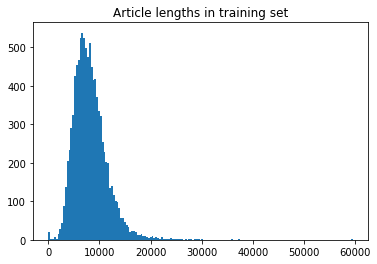

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")

# body includes abstract
texts = train_df['body'].to_list()
text_sizes = []
for text in texts:
    # tokenise before looking at text length in case they use BPE or subwords etc.
    input = tokenizer(text, return_tensors='pt', truncation=False, padding=False)
    text_sizes.append(input.input_ids.size()[1])
    
_ = plt.hist(text_sizes, bins='auto')
plt.title("Article lengths in training set")
plt.show()